# Parametric ML and Bayesian regression

    Notebook version: 1.2 (Sep 28, 2018)

    Authors: Miguel Lázaro Gredilla
             Jerónimo Arenas García (jarenas@tsc.uc3m.es)
             Jesús Cid Sueiro (jesus.cid@uc3m.es)

    Changes: v.1.0 - First version. Python version
             v.1.1 - Python 3 compatibility. ML section.
             v.1.2 - Revised content. 2D visualization removed.
    
    Pending changes: 

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import scipy.io       # To read matlab files
from scipy import spatial
import pylab
pylab.rcParams['figure.figsize'] = 8, 5

## 1. Introduction

In this exercise the student will review several key concepts of Maximum Likelihood and Bayesian regression. To do so, we will assume the regression model

$$s = f({\bf x}) + \varepsilon$$

where $s$ is the output corresponding to input ${\bf x}$, $f({\bf x})$ is an unobservable latent function, and $\varepsilon$ is white zero-mean Gaussian noise, i.e., 

$$\varepsilon \sim {\cal N}(0,\sigma_\varepsilon^2).$$

In addition, we will assume that the latent function is *linear in the parameters*

$$f({\bf x}) = {\bf w}^\top {\bf z}$$

where ${\bf z} = T({\bf x})$ is a possibly non-linear transformation of the input. Along this notebook, we will explore different types of transformations.

Also, we will assume an <i>a priori</i> distribution for ${\bf w}$ given by

$${\bf w} \sim {\cal N}({\bf 0}, \sigma_p^2~{\bf I})$$



### Practical considerations

   - Though sometimes unavoidable, it is recommended not to use explicit matrix inversion whenever possible. For instance, if an operation like ${\mathbf A}^{-1} {\mathbf b}$ must be performed, it is preferable to code it using python $\mbox{numpy.linalg.lstsq}$ function (see http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html), which provides the LS solution to the overdetermined system ${\mathbf A} {\mathbf w} = {\mathbf b}$.
   
   - Sometimes, the computation of $\log|{\mathbf A}|$ (where ${\mathbf A}$ is a positive definite matrix) can overflow available precision, producing incorrect results. A numerically more stable alternative, providing the same result is $2\sum_i \log([{\mathbf L}]_{ii})$, where $\mathbf L$ is the Cholesky decomposition of $\mathbf A$ (i.e., ${\mathbf A} = {\mathbf L}^\top {\mathbf L}$), and $[{\mathbf L}]_{ii}$ is the $i$th element of the diagonal of ${\mathbf L}$.
   
   - Non-degenerate covariance matrices, such as the ones in this exercise, are always positive definite. It may happen, as a consequence of chained rounding errors, that a matrix which was mathematically expected to be positive definite, turns out not to be so. This implies its Cholesky decomposition will not be available. A quick way to palliate this problem is by adding a small number (such as $10^{-6}$) to the diagonal of such matrix.

### Reproducibility of computations

To guarantee the exact reproducibility of the experiments, it may be useful to start your code initializing the seed of the random numbers generator, so that you can compare your results with the ones given in this notebook.

In [2]:
np.random.seed(3)

## 2. Data generation with a linear model

During this section, we will assume affine transformation
$${\bf z} = T({\bf x}) = (1, {\bf x}^\top)^\top$$.

The <i>a priori</i> distribution of ${\bf w}$ is assumed to be

$${\bf w} \sim {\cal N}({\bf 0}, \sigma_p^2~{\bf I})$$

### 2.1. Synthetic data generation

First, we are going to generate synthetic data (so that we have the ground-truth model) and use them to make sure everything works correctly and our estimations are sensible.

* [1] Set parameters $\sigma_p^2 = 2$ and $\sigma_{\varepsilon}^2 = 0.2$. To do so, define variables `sigma_p` and `sigma_eps` containing the respective standard deviations.

In [3]:
# Parameter settings
sigma_p = np.sqrt(2)
sigma_eps = np.sqrt(0.2)

* [2] Generate a weight vector $\mbox{true_w}$ with two elements from the <i>a priori</i> distribution of the weights. This vector determines the regression line that we want to find (i.e., the optimum unknown solution).

In [4]:
# Data dimension:
dim_x = 2

# Generate a parameter vector taking a random sample from the prior distributions
# (the np.random module may be usefull for this purpose)
true_w = np.random.normal(loc=0, scale=sigma_p, size=dim_x)

print('The true parameter vector is:')
print(true_w)

The true parameter vector is:
[2.52950265 0.61731815]


* [3] Generate an input matrix ${\bf X}$ (in this case, a single column) containing 20 samples with equally spaced values between 0 and 2 (method `linspace` from numpy can be useful for this)

In [5]:
n_points = 20
X = np.linspace(0, 2, 20)[:, np.newaxis]

* [4] Finally, generate the output vector ${\mbox s}$ as the product $\mbox{X} \ast \mbox{true_w}$ plus Gaussian noise of pdf ${\cal N}(0,\sigma_\varepsilon^2)$ at each element.

In [6]:
# Expand input matrix with an all-ones column
col_1 = np.ones((n_points, 1))
Z = np.hstack((col_1, X))
# Generate values of the target variable
s = np.matmul(Z, true_w) + np.random.normal(loc=0, scale=sigma_eps, size=(n_points))

### 2.2. Data visualization

* Plot the generated data. You will notice a linear behavior, but the presence of noise makes it hard to estimate precisely the original straight line that generated them (which is stored in $\mbox{true_w}$).

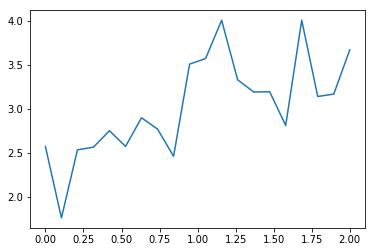

In [7]:
fig, ax = plt.subplots()

ax.plot(X, s)

## 3. Maximum Likelihood (ML) regression

### 3.1. Likelihood function

* [1] Define a function `predict(w, Z)` that computes the linear predictions for all inputs in data matrix `Z` (a 2-D numpy arry), for a given parameter vector `w` (a 1-D numpy array). The output should be a 1-D array. Test your function with the given dataset and `w = [0.4, 0.7]`

In [8]:
def predict(w, Z):
    return np.matmul(Z, w)

# Print predictions
w = np.array([0.4, 0.7])
p = predict(w, Z)
print(p)

[0.4        0.47368421 0.54736842 0.62105263 0.69473684 0.76842105
 0.84210526 0.91578947 0.98947368 1.06315789 1.13684211 1.21052632
 1.28421053 1.35789474 1.43157895 1.50526316 1.57894737 1.65263158
 1.72631579 1.8       ]


* [2] Define a function `sse(w, Z, s)` that computes the sum of squared errors (SSE) for the linear prediction with parameters `w ` (1D numpy array), inputs `Z `  (2D numpy array) and targets `s ` (1D numpy array). Using this function, compute the SSE of the true parameter vector in `true_w`.

In [9]:
def sse(w, Z, s):
    pred = predict(w, Z)
    return np.sum((pred - s) ** 2)

# SSE causado por el ruido, con los parámetros óptimos (los conocemos ya: true_w)
SSE = sse(true_w, Z, s)
print(" The SSE is: {0}".format(SSE))

 The SSE is: 3.4003613068704324


* [3] Define a function `likelihood(w, Z, s, sigma_eps)` that computes the likelihood of parameter vector `w` for a given dataset in matrix `Z` and vector `s`, assuming Gaussian noise with varianze $\sigma_\epsilon^2$. Note that this function can use the `sse` function defined above. Using this function, compute the likelihood of the true parameter vector in `true_w`.

In [10]:
def likelihood(w, Z, s, sigma_eps):
    K = len(s)
    lw = 1.0 / (np.sqrt(2*np.pi)*sigma_eps)**K * np.exp(- sse(w, Z, s)/(2*sigma_eps**2))
    return lw

L_w_true = likelihood(true_w, Z, s, sigma_eps)

print("The likelihood of the true parameter vector is {0}".format(L_w_true))

The likelihood of the true parameter vector is 2.0701698520505036e-05


* [4] Define a function `LL(w, Z, s, sigma_eps)` that computes the log-likelihood of parameter vector `w` for a given dataset in matrix `Z` and vector `s`, assuming Gaussian noise with varianze $\sigma_\epsilon^2$. Note that this function can use the `likelihood` function defined above. However, for a higher numerical precission, implemening a direct expression for the log-likelihood is recommended. 

   Using this function, compute the likelihood of the true parameter vector in `true_w`.

In [11]:
def LL(w, Z, s, sigma_eps):
    K = len(s)
    lw = -K*np.log(np.sqrt(2*np.pi)*sigma_eps) - sse(w, Z, s)/(2*sigma_eps**2)
    return lw

LL_w_true = LL(true_w, Z, s, sigma_eps)
print("The log-likelihood of the true parameter vector is {0}".format(LL_w_true))

The log-likelihood of the true parameter vector is -10.78529480692853


### 3.2. ML estimate

* [1] Compute the ML estimate of ${\bf w}$ given the data. Remind that using `np.linalg.lstsq` ia a better option than a direct implementation of the formula of the ML estimate, that would involve a matrix inversion.

In [12]:
w_ML = np.linalg.lstsq(Z, s, rcond=None)[0]

print(w_ML)

[2.39342127 0.63211186]


* [2] Compute the maximum likelihood, and the maximum log-likelihood.

In [13]:
L_w_ML = likelihood(w_ML, Z, s, sigma_eps)
LL_w_ML = LL(w_ML, Z, s, sigma_eps)

print('Maximum likelihood: {0}'.format(L_w_ML))
print('Maximum log-likelihood: {0}'.format(LL_w_ML))

Maximum likelihood: 4.3370620534450416e-05
Maximum log-likelihood: -10.045728292300279


Just as an illustration, the code below generates a set of points in a two dimensional grid going from $(-\sigma_p, -\sigma_p)$ to $(\sigma_p, \sigma_p)$, computes the log-likelihood for all these points and visualize them using a 2-dimensional plot. You can see the difference between the true value of the parameter ${\bf w}$ (black) and the ML estimate (red). If they are not quite close to each other, maybe you have made some mistake in the above exercises:

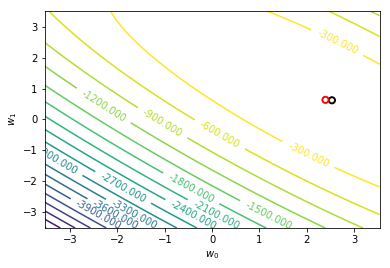

In [14]:
# First construct a grid of (theta0, theta1) parameter pairs and their
# corresponding cost function values.
N = 200    # Number of points along each dimension.
w0_grid = np.linspace(-2.5*sigma_p, 2.5*sigma_p, N)
w1_grid = np.linspace(-2.5*sigma_p, 2.5*sigma_p, N)

Lw = np.zeros((N,N))
# Fill Lw with the likelihood values
for i, w0i in enumerate(w0_grid):
    for j, w1j in enumerate(w1_grid):
        we = np.array((w0i, w1j)) 
        Lw[i, j] = LL(we, Z, s, sigma_eps)

WW0, WW1 = np.meshgrid(w0_grid, w1_grid, indexing='ij')
contours = plt.contour(WW0, WW1, Lw, 20)

plt.figure
plt.clabel(contours)
plt.scatter([true_w[0]]*2, [true_w[1]]*2, s=[50,10], color=['k','w'])
plt.scatter([w_ML[0]]*2, [w_ML[1]]*2, s=[50,10], color=['r','w'])
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.show()

### 3.3. [OPTIONAL]: Convergence of the ML estimate for the true model

Note that the likelihood of the true parameter vector is, in general, smaller than that of the ML estimate. However, as the sample size increasis, both should converge to the same value.

* [1] Generate a longer dataset, with $K_\text{max}=2^{16}$ samples, uniformly spaced between 0 and 2. Store it in the 2D-array `X2` and the 1D-array `s2`

In [15]:
# Parameter settings
x_min = 0
x_max = 2
n_points = 2**16

X2 = np.random.uniform(0, 2, n_points)
# s2 = 

* [2] Compute the ML estimate based on the first $2^k$ samples, for $k=2,3,\ldots, 15$. For each value of $k$ compute the squared euclidean distance between the true parameter vector and the ML estimate. Represent it graphically (using a logarithmic scale in the y-axis).

In [17]:
# <SOL>
# </SOL>

## 4. ML estimation with real data. The stocks dataset.

Once our code has been tested on synthetic data, we will use it with real data. 

### 4.1. Dataset

* [1] Load data corresponding to the evolution of the stocks of 10 airline companies. This data set is an adaptation of the Stock dataset from http://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html, which in turn was taken from the StatLib Repository, http://lib.stat.cmu.edu/

In [18]:
matvar = scipy.io.loadmat('DatosLabReg.mat')
Xtrain = matvar['Xtrain']
Xtest = matvar['Xtest']
strain = matvar['Ytrain']
stest = matvar['Ytest']

* [2] Normalize the data so all training sample components have zero mean and unit standard deviation. Store the normalized training and test samples in 2D numpy arrays `Xtrain` and `Xtest`, respectively.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

### 4.2. Polynomial ML regression with a single variable

In this first part, we will work with the first component of the input only.

* [1] Take the first column of `Xtrain` and `Xtest` into arrays `X0train` and `X0test`, respectively. 

In [46]:
X0train = Xtrain[:,0]
X0test = Xtest[:,0]

* [2] Visualize, in a single scatter plot, the target variable (in the vertical axes) versus the input variable, using the training data

Text(0.5,1,'Target vs. first feature')

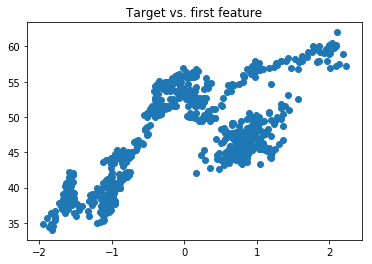

In [26]:
fig, ax = plt.subplots()

ax.scatter(X0train, strain)
ax.set_title('Target vs. first feature')

* [3] Since the data have been taken from a real scenario, we do not have any *true* mathematical model of the process that generated the data. Thus, we will explore different models trying to take the one that fits better the training data.

  Assume a polinomial model given by
  $$
  {\bf z} = T({\bf x}) = (1, x_0, x_0^2, \ldots, x_0^{g-1})^\top.
  $$

  Compute matrices `Ztrain` and `Ztest` that result from applying the polynomial transformation to the inputs in `X0train` and `X0test` for a model with degree `g_max = 50`. The `np.vander()` method may be useful for this.
  
  Note that, despite `X0train` and `X0test` where normalized, you will need to re-normalize the transformed variables.
  
  Note, also, that the first component of the transformed variables, which must be equal to 1, should not be normalized. To simplify the job, the code below defines a normalizer class that performs normalization to all components unless for the first one.

In [54]:
# The following normalizer will be helpful: it normalizes all components of the 
# input matrix, unless for the first one (the "all-one's" column) that
# should not be normalized
class Normalizer():
    """
    A data normalizer. Usage:
        nm = Normalizer()
        Z = nm.fit_transform(X)  # to estimate the normalization mean and variance an normalize 
                                 # all columns of X unles the first one
        Z2 = nm.transform(X)     # to normalize X without recomputing mean and variance parameters
   """
    
    def fit_transform(self, Z):
        
        self.mean_z = np.mean(Z, axis=0)
        self.mean_z[0] = 0
        self.std_z = np.std(Z, axis=0)
        self.std_z[0] = 1
        Zout = (Z - self.mean_z) / self.std_z
        
        # sc = StandardScaler()
        # Ztrain = sc.fit_transform(Ztrain)
        return Zout
        
    def transform(self, Z):        
        return (Z - self.mean_z) / self.std_z
        # Ztest = sc.transform(Ztest)
        
# Set the maximum degree of the polynomial model
g_max = 50

# Compute polynomial transformation for train and test data
norm = Normalizer()

# Normalize training and test data 
Ztrain = norm.fit_transform(np.vander(X0train, g_max, increasing=True))
Ztest = norm.transform(np.vander(X0test, g_max, increasing=True))

* [4] Fit a polynomial model with degree $g$ for $g$ ranging from 0 to `g_max`. Store the weights of all models in a list of weight vectors, named `models`, such that `models[g]` returns the parameters estimated for the polynomial model with degree $g$. 

  We will use these models in the following sections.

In [77]:
# IMPORTANT NOTE: Use np.linalg.lstsq() with option rcond=-1 for better precission.

# HINT: Take into account that the data matrix required to fit a polynomial model 
#       with degree g consists of the first g+1 columns of Ztrain.
w_ML = []
for g in range(g_max+1):
    w_ML.append(np.linalg.lstsq(Ztrain[:,:g+1], strain, rcond=-1)[0])


* [5] Plot the polynomial models with degrees 1, 3 and `g_max`, superimposed over a scatter plot of the training data.

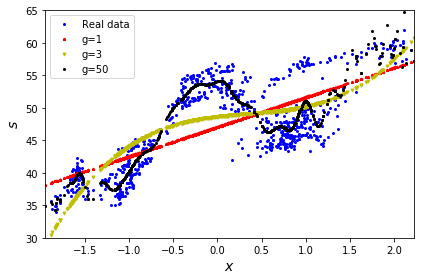

In [103]:
# Create a grid of samples along the x-axis.
n_points = 10000
xmin = min(X0train)
xmax = max(X0train)
X = np.linspace(xmin, xmax, n_points)[:, np.newaxis]

# Apply the polynomial transformation to the inputs with degree g_max.
predictions_50 = np.matmul(Z, w_ML[-1])
predictions_1 = np.matmul(Z[:,:2], w_ML[1])
predictions_3 = np.matmul(Z[:,:4], w_ML[3])

# Plot training points
plt.plot(X0train, strain, 'b.', markersize=4);
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);
plt.xlim(xmin, xmax)
plt.ylim(30, 65)

# Plot the regresion function for the required degrees
plt.plot(X0train, predictions_1, 'r*', markersize=3)
plt.plot(X0train, predictions_3, 'yv', markersize=3)
plt.plot(X0train, predictions_50, 'ko', markersize=2)

plt.legend(['Real data', 'g=1', 'g=3', 'g=50'], loc='best')
plt.tight_layout()
plt.show()



* [6] Taking `sigma_eps = 1`, show, in the same plot:

  - The log-likelihood function corresponding to each model, as a function of $g$, computed over the training set.
  - The log-likelihood function corresponding to each model, as a function of $g$, computed over the test set.
  
  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


ValueError: x and y must have same first dimension, but have shapes (51,) and (0,)

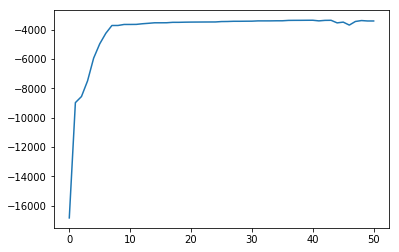

In [110]:
LLtrain = []
LLtest = []
sigma_eps = 1

# Fill LLtrain and LLtest with the log-likelihood values for all values of
# g ranging from 0 to g_max (included).
for g in range(g_max+1):
    print(g)
    LLtrain.append(LL(w_ML[g], Z[:,:g+1], strain, sigma_eps))

plt.figure()
plt.plot(range(g_max + 1), LLtrain, label='Training')
plt.plot(range(g_max + 1), LLtest, label='Test')
plt.xlabel('g')
plt.ylabel('Log-likelihood')
plt.xlim(0, g_max)
plt.ylim(-5e4,100)
plt.legend()
plt.show()

In [108]:
w_ML[50].shape

(50, 1)

In [109]:
Z[:,:51].shape

(760, 50)

* [7] You may have seen the likelihood function over the training data grows with the degree of the polynomial. However, large values of $g$ produce a strong data overfitting. For this reasong, $g$ cannot be selected with the same data used to fit the model. 

  This kind of parameters, like $g$ are usually called *hyperparameters* and need to be selected by cross validation.

  Select the optimal value of $g$ by 10-fold cross-validation. To do so, the cross validation methods provided by sklearn will simplify this task.

In [ ]:
from sklearn.model_selection import KFold

# Select the number of splits
n_sp = 10

# Create a cross-validator object
kf = KFold(n_splits=n_sp)
# Split data from Ztrain
kf.get_n_splits(Ztrain)

LLmean = []
for g in range(g_max + 1):
    # Compute the cross-validation Likelihood
    LLg = 0
    for tr_index, val_index in kf.split(Ztrain):
        # Take the data matrices for the current split
        Z_tr, Z_val = Ztrain[tr_index, 0:g+1], Ztrain[val_index, 0:g+1]
        s_tr, s_val = strain[tr_index], strain[val_index]

        # Train with the current training splits.
        # w_MLk, _, _, _ = np.linalg.lstsq(<FILL IN>)

        # Compute the validation likelihood for this split
        # LLg += LL(<FILL IN>)

    LLmean.append(LLg / n_sp)

# Take the optimal value of g and its correpsponding likelihood
# g_opt = <FILL IN>
# LLmax = <FILL IN>

print("The optimal degree is: {}".format(g_opt))
print("The maximum cross-validation likehood is {}".format(LLmax))

plt.figure()
plt.plot(range(g_max + 1), LLmean, label='Training')
plt.plot([g_opt], [LLmax], 'g.', markersize = 20)
plt.xlabel('g')
plt.ylabel('Log-likelihood')
plt.xlim(0, g_max)
plt.ylim(-1e3, LLmax + 100)
plt.legend()
plt.show()

* [8] You may have observed the overfitting effect for large values of $g$. The best degree of the polynomial may depend on the size of the training set. Take a smaller dataset by running, after the code in section 4.2[1]:

 + `X0train = Xtrain[0:55, [0]]`
 + `X0test = Xtest[0:100, [0]]`

   Then, re-run the whole code after that. What is the optimal value of $g$ in that case?

In [ ]:
# You do not need to code here. Just copy the value of g_opt obtained after re-running the code
# g_opt_new = <FILL IN>

print("The optimal value of  g for the 100-sample training set is {}".format(g_opt_new))


* [9] [OPTIONAL]   

  Note that the model coefficients do not depend on $\sigma_\epsilon^2$. Therefore, we do not need to care about its values for polynomial ML regression.

  However, the log-likelihood function do depends on $\sigma_\epsilon^2$. Actually, we can estimate its value by cross-validation. By simple differentiation, it is not difficult to see that the optimal ML estimate of $\sigma_\epsilon$ is

  $$
  \widehat{\sigma}_\epsilon^2 = \sqrt{\frac{1}{K} \|{\bf s}-{\bf Z}{\bf w}\|^2}
  $$

  Plot the log-likelihood function corresponding to the polynomial model with degree 3 for different values of $\sigma_\epsilon^2$, for the training set, and verify that the value computed with the above formula is actually optimal.

In [ ]:
# Explore the values of sigma logarithmically spaced according to the following array
sigma_eps = np.logspace(-0.1, 5, num=50)

g = 3
K = len(strain)

# <SOL>
# </SOL>

* [10] [OPTIONAL] For the selected model:

    - Plot the regresion function over the scater plot of the data.
    - Compute the log-likelihood and the SSE over the test set.

In [ ]:
# Note that you can easily adapt your code in 4.2[5]

# <SOL>
# </SOL>

## 5. Bayesian regression. The stock dataset.

In this section we will keep using the first component of the data from the stock dataset, assuming the same kind of plolynomial model. We will explore the potential advantages of using a Bayesian model. To do so, we will asume that the <i>a priori</i> distribution of ${\bf w}$ is

$${\bf w} \sim {\cal N}({\bf 0}, \sigma_p^2~{\bf I})$$


### 5.1. Hyperparameter selection

Since the values $\sigma_p$ and $\sigma_\varepsilon$ are no longer known, a first rough estimation is needed (we will soon see how to estimate these values in a principled way).

To this end, we will adjust them using the ML solution to the regression problem with g=10:

   - $\sigma_p^2$ will be taken as the average of the square values of ${\hat {\bf w}}_{ML}$
   - $\sigma_\varepsilon^2$ will be taken as two times the average of the square of the residuals when using ${\hat {\bf w}}_{ML}$

In [ ]:
# Degree for bayesian regression
gb = 10

# w_LS, residuals, rank, s = <FILL IN>

# sigma_p = <FILL IN>
# sigma_eps = <FILL IN>

print(sigma_p)
print(sigma_eps)

### 5.2. Posterior pdf of the weight vector

In this section we will visualize prior and the posterior distribution functions. First, we will restore the dataset at the begining of this notebook:

* [1] Define a function `posterior_stats(Z, s, sigma_eps, sigma_p)` that computes the parameters of the posterior coefficient distribution given the dataset in matrix `Z` and vector `s`, for given values of the hyperparameters.
This function should return the posterior mean, the covariance matrix and the precision matrix (the inverse of the covariance matrix). Test the function to the given dataset, for $g=3$.

In [ ]:
# <SOL>
# </SOL>

mean_w, Cov_w, iCov_w = posterior_stats(Ztrain[:, :gb+1], strain, sigma_eps, sigma_p)

print('mean_w = {0}'.format(mean_w))
# print('Cov_w = {0}'.format(Cov_w))
# print('iCov_w = {0}'.format(iCov_w))

* [2] Define a function `gauss_pdf(w, mean_w, iCov_w)` that computes the Gaussian pdf with mean `mean_w` and precision matrix `iCov_w`. Use this function to compute and compare the ML estimate and the MSE estimate, given the dataset.

In [ ]:
# <SOL>
# </SOL>

print('p(w_ML | s)  = {0}'.format(gauss_pdf(w_ML, mean_w, iCov_w)))
print('p(w_MSE | s)  = {0}'.format(gauss_pdf(mean_w, mean_w, iCov_w)))

* [3] [OPTIONAL] Define a function `log_gauss_pdf(w, mean_w, iCov_w)` that computes the log of the Gaussian pdf with mean `mean_w` and precision matrix `iCov_w`. Use this function to compute and compare the log of the posterior pdf value of the true coefficients, the ML estimate and the MSE estimate, given the dataset.

In [ ]:
# <SOL>
# </SOL>

print('log(p(w_ML | s))  = {0}'.format(log_gauss_pdf(w_ML, mean_w, iCov_w)))
print('log(p(w_MSE | s))  = {0}'.format(log_gauss_pdf(mean_w, mean_w, iCov_w)))

### 5.3 Sampling regression curves from the posterior

In this section we will plot the functions corresponding to different samples drawn from the posterior distribution of the weight vector. 

To this end, we will first generate an input dataset of equally spaced samples. We will compute the functions at these points

In [ ]:
# Definition of the interval for representation purposes 
xmin = min(X0train)
xmax = max(X0train)
n_points = 100   # Only two points are needed to plot a straigh line

# Build the input data matrix:
# Input values for representation of the regression curves
X = np.linspace(xmin, xmax, n_points)
Z = np.vander(X.flatten(), g_max+1, increasing=True)
Z = nm.transform(Z)[:, :gb+1]

Generate random vectors ${\bf w}_l$ with $l = 1,\dots, 50$, from the posterior density of the weights, $p({\bf w}\mid{\bf s})$, and use them to generate 50 polinomial regression functions, $f({\bf x}^\ast) = {{\bf z}^\ast}^\top {\bf w}_l$, with ${\bf x}^\ast$ between $-1.2$ and $1.2$, with step $0.1$.

Plot the line corresponding to the model with the posterior mean parameters, along with the $50$ generated straight lines and the original samples, all in the same plot. As you can check, the Bayesian model is not providing a single answer, but instead a density over them, from which we have extracted 50 options.

In [ ]:
# Drawing weights from the posterior
for l in range(50):
    # Generate a random sample from the posterior distribution (you can use np.random.multivariate_normal())
    # w_l = <FILL IN>

    # Compute predictions for the inputs in the data matrix
    # p_l = <FILL IN>

    # Plot prediction function
    # plt.plot(<FILL IN>, 'c:');

# Plot the training points
plt.plot(X0train, strain,'b.',markersize=2);
plt.xlim((xmin, xmax));
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);

### 5.4. Plotting the confidence intervals

On top of the previous figure (copy here your code from the previous section), plot functions

$${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}$$

and

$${\mathbb E}\left\{f({\bf x}^\ast)\mid{\bf s}\right\} \pm 2 \sqrt{{\mathbb V}\left\{f({\bf x}^\ast)\mid{\bf s}\right\}}$$

(i.e., the posterior mean of $f({\bf x}^\ast)$, as well as two standard deviations above and below).

It is possible to show analytically that this region comprises $95.45\%$ probability of the posterior probability $p(f({\bf x}^\ast)\mid {\bf s})$ at each ${\bf x}^\ast$.

In [ ]:
# Note that you can re-use code from sect. 4.2 to solve this exercise

# Plot the training points 
# plt.plot(X, Z.dot(true_w), 'b', label='True model', linewidth=2);
plt.plot(X0train, strain,'b.',markersize=2);
plt.xlim(xmin, xmax);
# </SOL>    

# Plot the posterior mean.
# mean_s = <FILL IN>
plt.plot(X, mean_ast, 'g', label='Predictive mean', linewidth=2);

# Plot the posterior mean +- two standard deviations
# std_f = <FILL IN>

# Plot the confidence intervals.
# To do so, you can use the fill_between method
plt.fill_between(X, (mean_s - 2*std_f).flatten(), (mean_s + 2*std_f).flatten(),
                 alpha=0.4, edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=2)

# plt.legend(loc='best')
plt.xlabel('$x$',fontsize=14);
plt.ylabel('$s$',fontsize=14);
plt.show()


Plot now ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\} \pm 2 \sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ (note that the posterior means of $f({\bf x}^\ast)$ and $s({\bf x}^\ast)$ are the same, so there is no need to plot it again). Notice that $95.45\%$ of observed data lie now within the newly designated region. These new limits establish a confidence range for our predictions. See how the uncertainty grows as we move away from the interpolation region to the extrapolation areas.

In [ ]:
# Plot sample functions confidence intervals and sampling points
# Note that you can simply copy and paste most of the code used in the cell above.
# <SOL>
# </SOL>

plt.show()

### 5.5. Test square error

* [1] To test the regularization effect of the Bayesian prior. To do so, compute and plot the sum of square errors of both the ML and Bayesian estimates as a function of the polynomial degree.


In [ ]:
SSE_ML = []
SSE_Bayes = []

# Compute the SSE for the ML and the bayes estimates
for g in range(g_max + 1):
    # <SOL>
    # </SOL>

plt.figure()
plt.semilogy(range(g_max + 1), SSE_ML, label='ML')
plt.semilogy(range(g_max + 1), SSE_Bayes, 'g.', label='Bayes')
plt.xlabel('g')
plt.ylabel('Sum of square errors')
plt.xlim(0, g_max)
plt.ylim(min(min(SSE_Bayes), min(SSE_ML)),10000)
plt.legend()
plt.show()


### 5.6. [Optional] Model assessment

In order to verify the performance of the resulting model, compute the posterior mean and variance of each of the test outputs from the posterior over ${\bf w}$. I.e, compute ${\mathbb E}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}$ and $\sqrt{{\mathbb V}\left\{s({\bf x}^\ast)\mid{\bf s}\right\}}$ for each test sample ${\bf x}^\ast$ contained in each row of `Xtest`. 

Store the predictive mean and variance of all test samples in two column vectors called `m_s` and `v_s`, respectively.

In [ ]:
# <SOL>
# </SOL>

Compute now the mean square error (MSE) and the negative log-predictive density (NLPD) with the following code:

In [ ]:
# <SOL>
# </SOL>

print('MSE = {0}'.format(MSE))
print('NLPD = {0}'.format(NLPD))

These two measures reveal the quality of our predictor (with lower values revealing higher quality). The first measure (MSE) only compares the predictive mean with the actual value and always has a positive value (if zero was reached, it would mean a perfect prediction). It does not take into account predictive variance. The second measure (NLPD) takes into account both the deviation and the predictive variance (uncertainty) to measure the quality of the probabilistic prediction (a high error in a prediction that was already known to have high variance has a smaller penalty, but also, announcing a high variance when the prediction error is small won’t award such a good score).

## 6. Regression with all variables from the stocks dataset.

Try to improve the test SSE of the best model used so far. To do so:

* Explore the use of all the input variables from the dataset.
* Explore other regression algorithms from the `sklearn` library.